In [1]:
!pip install -U keras-efficientnet-v2 plotly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.6/15.6 MB 71.5 MB/s eta 0:00:00
  Attempting uninstall: plotly
    Found existing installation: plotly 5.15.0
    Uninstalling plotly-5.15.0:
      Successfully uninstalled plotly-5.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


In [2]:
from tensorflow.keras.utils import img_to_array, plot_model, image_dataset_from_directory
from tensorflow import cast, float32, uint8, expand_dims, random
from tensorflow.data import AUTOTUNE
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
from tensorflow.keras import Input, Model, backend
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import VarianceScaling
from tensorflow.keras.regularizers import L2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Activation, BatchNormalization, RandomRotation, RandomFlip, Rescaling, RandomBrightness, RandomHeight, RandomWidth, RandomTranslation
from tensorflow.keras.models import Sequential
import keras_efficientnet_v2

from numpy import argmax, max, array
import matplotlib.pyplot as plt
import gdown
import os
from PIL.Image import open
from urllib.request import urlopen
from io import BytesIO
import IPython.display as display
from plotly.subplots import make_subplots
import plotly.graph_objects as go

random.set_seed(42)

In [3]:
#@title Plotting Function (Run This)
class PlotTraining(Callback):
  def __init__(self, sample_rate=1, zoom=1):
    self.sample_rate = sample_rate
    self.step = 0
    self.zoom = zoom
    self.steps_per_epoch = 32

  def on_train_begin(self, logs={}):
    self.batch_history = {}
    self.batch_step = []
    self.epoch_history = {}
    self.epoch_step = []
    self.fig, self.axes = plt.subplots(1, 2, figsize=(16, 7))
    plt.ioff()

  def on_batch_end(self, batch, logs={}):
    if (batch % self.sample_rate) == 0:
      self.batch_step.append(self.step)
      for k,v in logs.items():
        # do not log "batch" and "size" metrics that do not change
        # do not log training accuracy "acc"
        if k=='batch' or k=='size':# or k=='acc':
          continue
        self.batch_history.setdefault(k, []).append(v)
    self.step += 1

  def on_epoch_end(self, epoch, logs={}):
    plt.close(self.fig)
    self.axes[0].cla()
    self.axes[1].cla()

    self.axes[0].set_ylim(0, 1.2/self.zoom)
    self.axes[1].set_ylim(1-1/self.zoom/2, 1+0.1/self.zoom/2)

    self.epoch_step.append(self.step)
    for k,v in logs.items():
      # only log validation metrics
      if not k.startswith('val_'):
        continue
      self.epoch_history.setdefault(k, []).append(v)

    display.clear_output(wait=True)

    for k,v in self.batch_history.items():
      self.axes[0 if k.endswith('loss') else 1].plot(array(self.batch_step) / self.steps_per_epoch, v, label=k)

    for k,v in self.epoch_history.items():
      self.axes[0 if k.endswith('loss') else 1].plot(array(self.epoch_step) / self.steps_per_epoch, v, label=k, linewidth=3)

    self.axes[0].legend()
    self.axes[1].legend()
    self.axes[0].set_xlabel('epochs')
    self.axes[1].set_xlabel('epochs')
    self.axes[0].minorticks_on()
    self.axes[0].grid(True, which='major', axis='both', linestyle='-', linewidth=1)
    self.axes[0].grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
    self.axes[1].minorticks_on()
    self.axes[1].grid(True, which='major', axis='both', linestyle='-', linewidth=1)
    self.axes[1].grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
    display.display(self.fig)

def PlotResult(data1, data2, y_range : list, name1 : str, name2 : str, text : str, visible : bool, title : str):
  fig = go.Figure()

  fig.add_trace(go.Scatter(y=data1,
                      mode='lines+markers',
                      name=name1,
                      hoverinfo='text+y+name',
                      text=text,
                      marker=dict(color="#ff6a00")))
  fig.add_trace(go.Scatter(y=data2,
                      mode='lines+markers',
                      name=name2,
                      hoverinfo='text+y+name',
                      text=text,
                      marker=dict(color="#0f55fa")))
  fig.add_trace(go.Scatter(x=[19,19], y=[0,19],
                      mode='lines',
                      name='Start Fine Tuning',
                      hoverinfo='skip',
                      marker=dict(color="MediumPurple"),
                      visible=visible))

  fig.update_layout(
      xaxis=dict(
          title = 'Number of Epochs',
          showline=True,
          showgrid=False,
          showticklabels=True,
          linecolor='rgb(204, 204, 204)',
          linewidth=2,
          ticks='outside',
          tickfont=dict(
              family='Arial',
              size=12,
              color='rgb(82, 82, 82)',
          ),
      ),
      yaxis=dict(
          title =None,
          showgrid=False,
          showline=True,
          linecolor='rgb(204, 204, 204)',
          linewidth=2,
          showticklabels=True,
          tickfont=dict(
              family='Arial',
              size=12,
              color='rgb(82, 82, 82)',
          ),
      ),
      yaxis_range=y_range,
      plot_bgcolor='white',
      title =title,
      title_x=0.5,
      title_font_size=18
  )
  return fig.show()

In [4]:
!gdown 1xqd9M2uCFM1rmk0gmctnuacm2KMBQk_j
from zipfile import ZipFile
with ZipFile("/content/DATASET.zip", 'r') as zObject:
    zObject.extractall()

Downloading...
From: https://drive.google.com/uc?id=1xqd9M2uCFM1rmk0gmctnuacm2KMBQk_j
To: /content/DATASET.zip
100% 1.49G/1.49G [00:06<00:00, 230MB/s]


In [5]:
train = '/content/DATASET/train'
val = '/content/DATASET/val'
test = '/content/DATASET/test'

In [6]:
train_ds = image_dataset_from_directory(
  train,
  seed=42,
  shuffle=True,
  color_mode='rgb',
  image_size=(384, 384),
  batch_size=32)

val_ds = image_dataset_from_directory(
  val,
  seed=42,
  shuffle=True,
  color_mode='rgb',
  image_size=(384, 384),
  batch_size=32)

test_ds = image_dataset_from_directory(
  test,
  seed=42,
  shuffle=True,
  color_mode='rgb',
  image_size=(384, 384),
  batch_size=32)

Found 18653 files belonging to 114 classes.
Found 3420 files belonging to 114 classes.
Found 1140 files belonging to 114 classes.


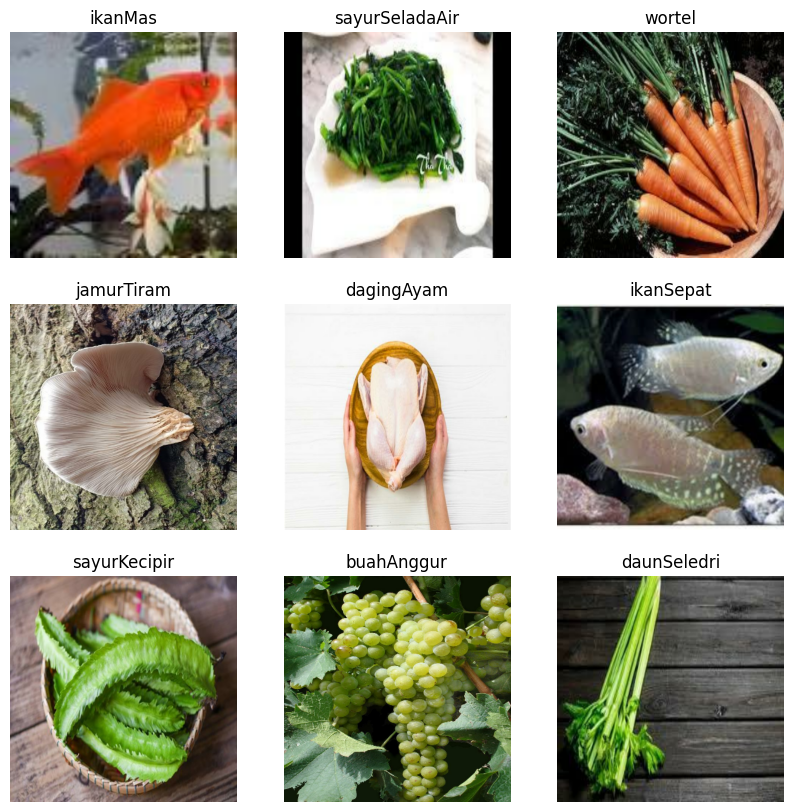

In [7]:
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:
data_augmentation = Sequential([
    RandomRotation(0.2),
    RandomFlip('horizontal'),
    RandomBrightness(0.2),
    RandomHeight(0.2),
    RandomWidth(0.2),
    RandomTranslation(0, 0.2),
    RandomTranslation(0.2, 0)
    ])

rescale = Rescaling(1./127.5, offset=-1)

In [10]:
efnet = keras_efficientnet_v2.EfficientNetV2S(input_shape=(384, 384, 3), num_classes=0, pretrained="imagenet21k", include_preprocessing=False)
efnet.trainable = False

backend.clear_session()
inputs = Input(shape=(384, 384, 3))
x = data_augmentation(inputs)
x = rescale(x)
x = efnet(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(1280, use_bias = False, kernel_initializer = VarianceScaling(seed=42), kernel_regularizer = L2(1e-4))(x)
x = BatchNormalization(center = True, scale = False)(x)
x = Activation('relu')(x)
x = Dropout(.3)(x)
outputs = Dense(114, activation = 'softmax', kernel_initializer = VarianceScaling(seed=42))(x)
model = Model(inputs, outputs)

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer VarianceScaling is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


194646348/194646348 [==============================] - 1s 0us/step
>>>> Load pretrained from: /root/.keras/models/efficientnetv2/efficientnetv2-s-21k.h5
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 384, 384, 3)]     0         
                                                                 
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 rescaling (Rescaling)       (None, None, None, 3)     0         
                                                                 
 EfficientNetV2S (Functiona  (None, 12, 12, 1280)      20331360  
 l)                                                              
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                

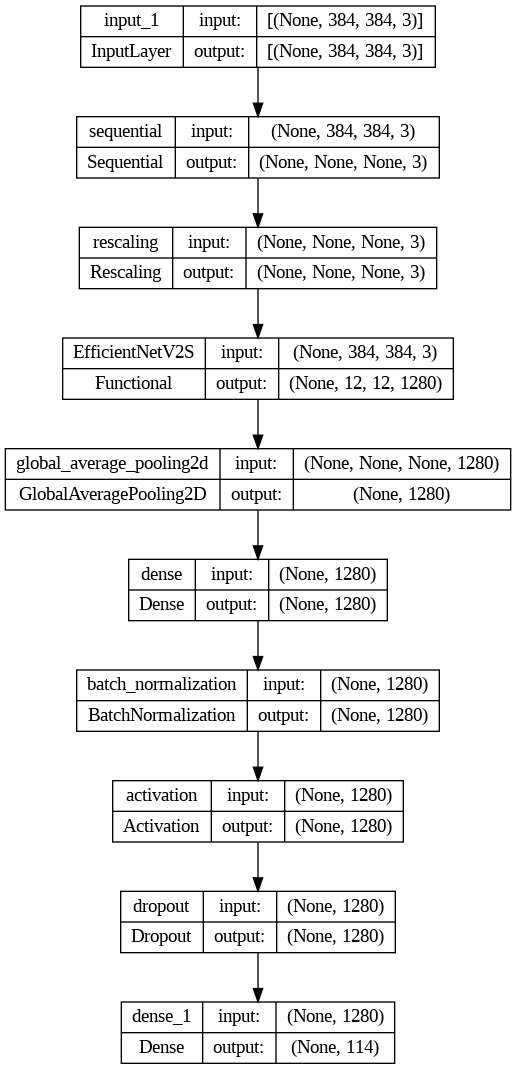

In [11]:
plot_model(model, show_shapes=True)

In [12]:
model.compile(loss= 'sparse_categorical_crossentropy',
              optimizer=Adam(learning_rate = 3e-4),
              metrics=['accuracy'])

plot_training = PlotTraining(sample_rate=20, zoom=1)

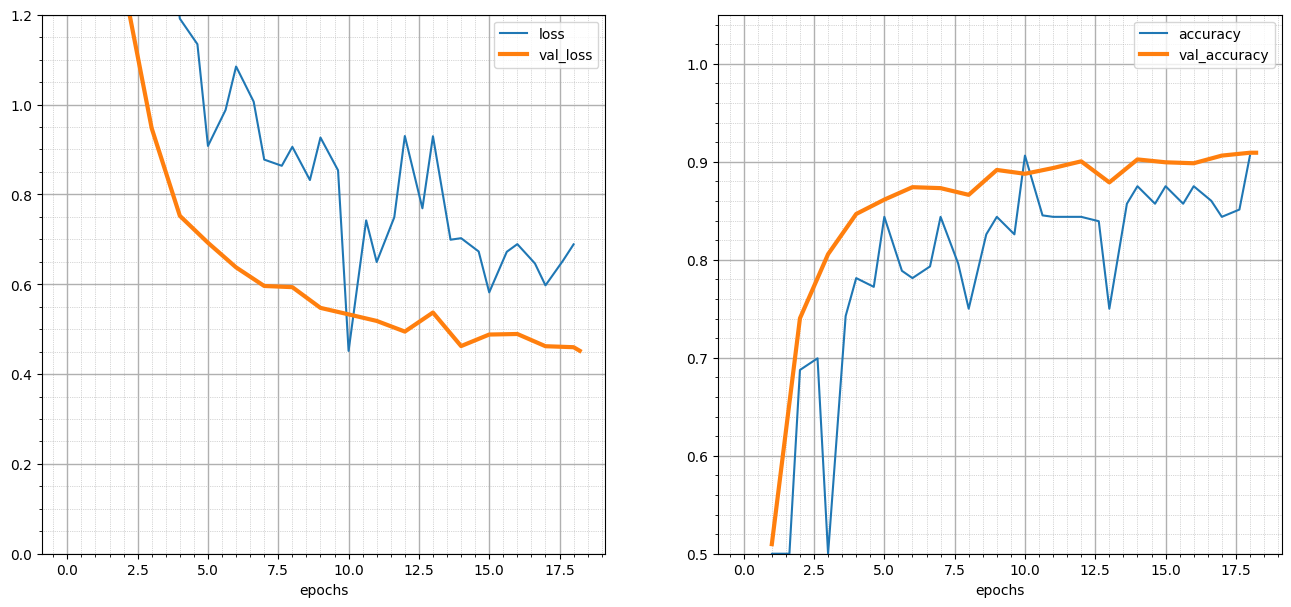

32/32 - 8s - loss: 0.6783 - accuracy: 0.8643 - val_loss: 0.4518 - val_accuracy: 0.9092 - 8s/epoch - 248ms/step


In [13]:
history = model.fit(
      train_ds,
      epochs=20,
      steps_per_epoch = 32,
      validation_data=val_ds,
      validation_steps = 32,
      callbacks=[plot_training],
      verbose=2)

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [15]:
PlotResult(data1 = acc,
           data2 = val_acc,
           y_range= [0, 1.0],
           name1 = "Training Accuracy",
           name2 = "Validation Accuracy",
           text = "Accuracy",
           visible=False,
           title ="Training vs Validation Accuracy")

In [16]:
PlotResult(data1 = loss,
           data2 = val_loss,
           y_range= [0, 4.0],
           name1 = "Training Loss",
           name2 = "Validation Loss",
           text = "Loss",
           visible=False,
           title ="Training vs Validation Loss")

In [17]:
model.evaluate(test_ds)

36/36 [==============================] - 5s 126ms/step - loss: 0.4481 - accuracy: 0.9123


[0.4481218159198761, 0.9122806787490845]

In [18]:
efnet.trainable = True

In [19]:
# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in efnet.layers[:fine_tune_at]:
  layer.trainable = False

# Let's take a look to see how many layers are in the base model
print(f"Number of layers in the base model: {len(efnet.layers)} and we will unfreeze layers start at layer {fine_tune_at}")

Number of layers in the base model: 508 and we will unfreeze layers start at layer 100


In [20]:
model.compile(loss= 'sparse_categorical_crossentropy',
              optimizer=Adam(learning_rate = 3e-4/10),
              metrics=['accuracy'])

plot_training = PlotTraining(sample_rate=20, zoom=2)

In [21]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 384, 384, 3)]     0         
                                                                 
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 rescaling (Rescaling)       (None, None, None, 3)     0         
                                                                 
 EfficientNetV2S (Functiona  (None, 12, 12, 1280)      20331360  
 l)                                                              
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1280)              163840

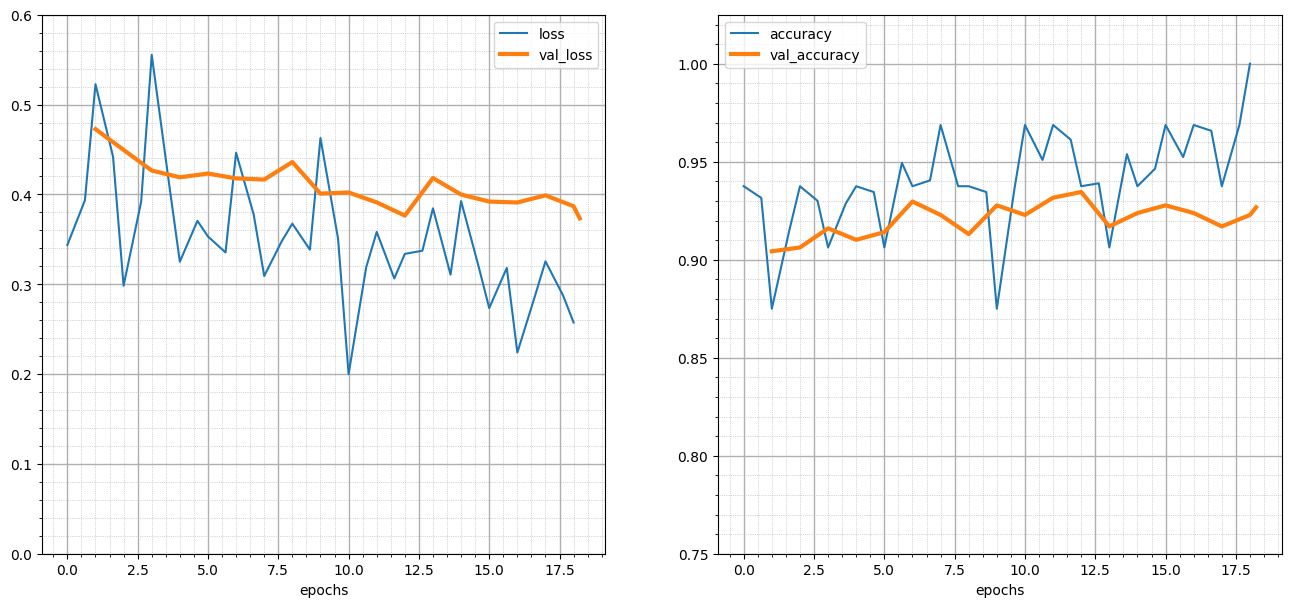

32/32 - 9s - loss: 0.3719 - accuracy: 0.9231 - val_loss: 0.3733 - val_accuracy: 0.9268 - 9s/epoch - 277ms/step


In [22]:
history_fine = model.fit(train_ds,
                         epochs=20 + 20,
                         steps_per_epoch = 32,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds,
                         validation_steps = 32,
                         callbacks=[plot_training],
                         verbose = 2)

In [23]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

In [24]:
PlotResult(data1 = acc,
           data2 = val_acc,
           y_range= [0, 1.0],
           name1 = "Training Accuracy",
           name2 = "Validation Accuracy",
           text = "Accuracy",
           visible=True,
           title ="Training vs Validation Accuracy")

In [25]:
PlotResult(data1 = loss,
           data2 = val_loss,
           y_range= [0, 4.0],
           name1 = "Training Loss",
           name2 = "Validation Loss",
           text = "Loss",
           visible=True,
           title ="Training vs Validation Loss")

In [26]:
model.evaluate(test_ds)

36/36 [==============================] - 4s 113ms/step - loss: 0.3896 - accuracy: 0.9325


[0.3895878493785858, 0.9324561357498169]

In [28]:
img_path = 'https://images.tokopedia.net/img/cache/900/hDjmkQ/2021/7/6/bb42e69e-143e-49bd-880a-3a89fce35836.jpg'

In [29]:
image_response = urlopen(img_path)
image_data = image_response.read()
image = open(BytesIO(image_data))
image = image.resize((384, 384))

img_array = img_to_array(image)
img_array = cast(expand_dims(img_array, 0), float32)
images = preprocess_input(img_array)

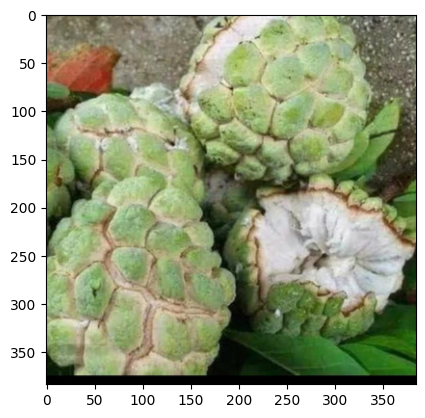

In [30]:
plt.imshow(cast(image, uint8))
plt.show()

In [31]:
predictions = model.predict(images, batch_size=32)

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[argmax(predictions)], 100 * max(predictions))
)

1/1 [==============================] - 3s 3s/step
This image most likely belongs to buahSrikaya with a 99.80 percent confidence.


In [32]:
model.save('/content/models.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

